In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive
dataset = !unzip Dataset.zip


/content/drive/MyDrive


In [ ]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

In [ ]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img

In [ ]:
import pathlib

data_dir = os.path.join('Dataset')
data_dir = pathlib.Path(data_dir)

In [ ]:
masked_dir = os.listdir(os.path.join(data_dir, 'Masked'))
forged_dir = os.listdir(os.path.join(data_dir,  'Forged'))
imglen = len(masked_dir)

<ipython-input-8-4a4e2cafb7a9>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1 + img[i])
<ipython-input-8-4a4e2cafb7a9>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2 + mask[i])


(256, 384, 3)
(256, 384, 4)
(256, 384, 3)
(256, 384)
(256, 384, 3)
(256, 384, 4)


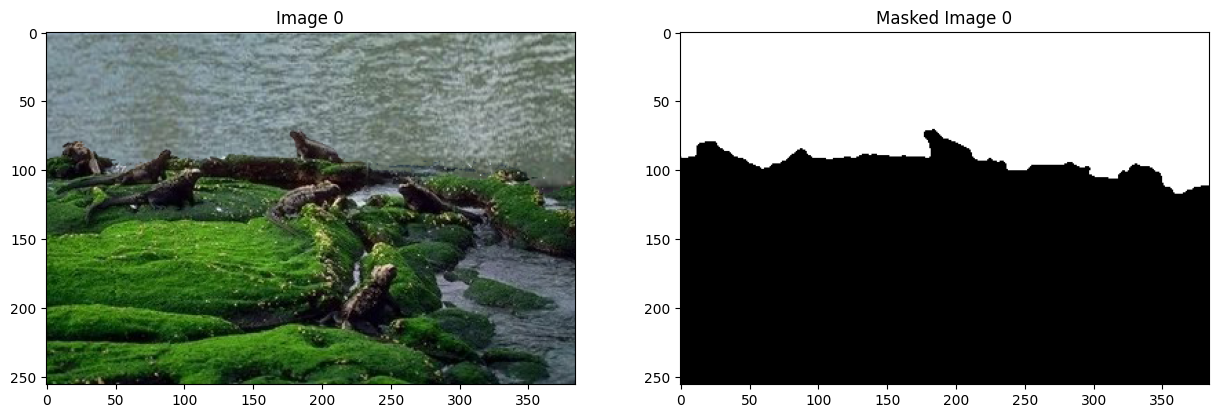

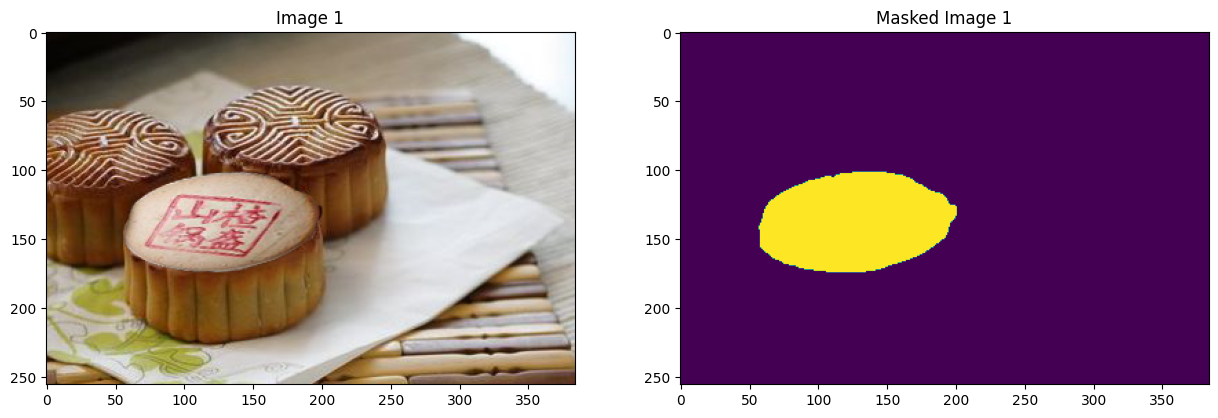

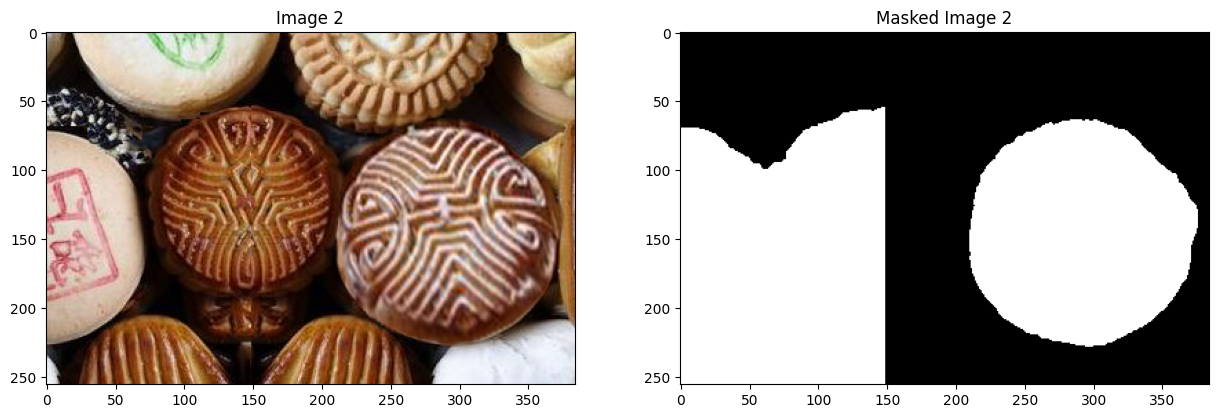

In [ ]:
# Call the apt function
path1 = '/content/drive/MyDrive/Dataset/Forged/'
path2 = '/content/drive/MyDrive/Dataset/Masked/'
img, mask = LoadData(path1, path2)

# View an example of image and corresponding mask
show_images = 3
for i in range(show_images):
    img_view  = imageio.imread(path1 + img[i])
    mask_view = imageio.imread(path2 + mask[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

In [ ]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img / 255.0
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path).convert('1')
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,1))
        # single_mask = single_mask / 255.0
        y[index] = single_mask
    return X,y

X Shape: (2000, 256, 256, 3)
Y shape: (2000, 256, 256, 1)
[0 1]


Text(0.5, 1.0, 'Processed Masked Image ')

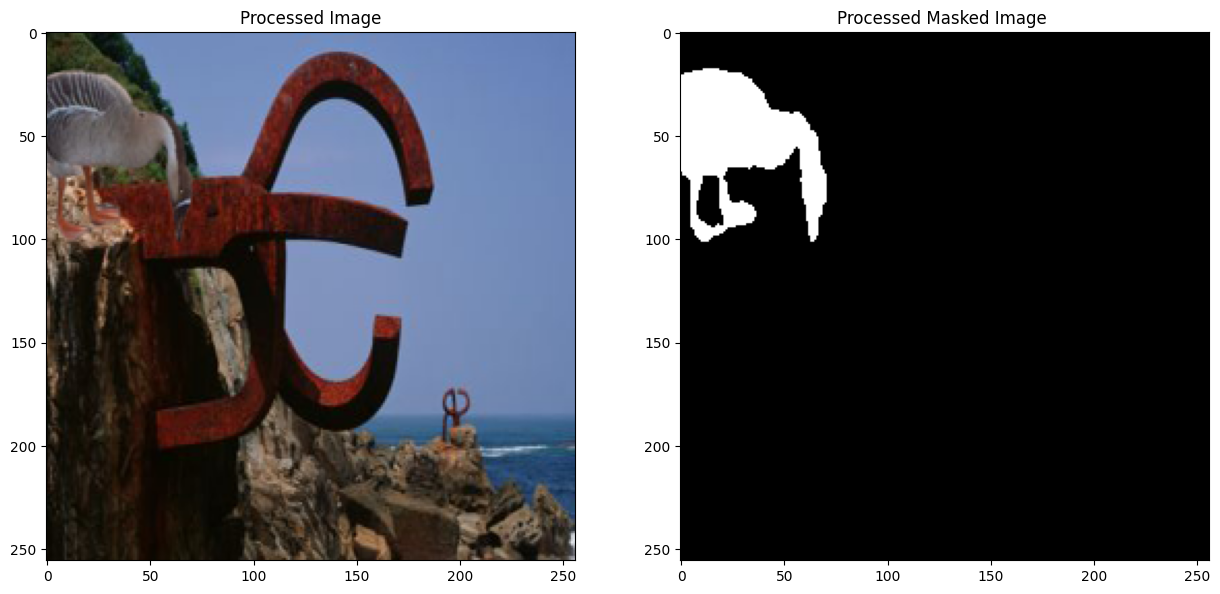

In [ ]:
# Define the desired shape
target_shape_img = [256, 256, 3]
target_shape_mask = [256, 256, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataseta
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 3 classes : background, pet, outline
print(np.unique(y))

# Visualize the output
image_index = 1470
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0], cmap='gray')
arr[1].set_title('Processed Masked Image ')


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose

def unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    up6 = concatenate([up6, drop4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(num_classes, 1, activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
num_classes = 2
# Create the MeanIoU metric
mean_iou = MeanIoU(num_classes=num_classes)

In [ ]:
# Example usage:
input_shape = (256, 256, 3)
num_classes = 1
with tf.device('/GPU:0'):
  model = unet(input_shape=(256, 256, 3), num_classes=1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import MeanIoU, Precision, Recall


# optimizer = Adam(learning_rate = 1e-3)
# # optimizer.build(unet.trainable_variables)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Define optimizer, loss function, and metrics
from tensorflow.keras.losses import BinaryCrossentropy
optimizer = Adam(learning_rate= 0.001)  # Adjust learning rate as needed
loss_fn = BinaryCrossentropy()  # For binary segmentation
metrics = [mean_iou]

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

# Define callbacks (optional)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Stop training if validation loss doesn't improve for 5 epochs
model_checkpoint = ModelCheckpoint('best_model.hdf5', save_best_only=True)  # Save the best model based on validation loss


In [ ]:
model.fit(X_train, y_train,
          epochs=20,  # Adjust number of epochs
          batch_size=16,  # Adjust batch size based on GPU memory
          validation_data=(X_valid, y_valid),
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.4530 - mean_io_u: 0.4253

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 147s 1s/step - loss: 0.4530 - mean_io_u: 0.4253 - val_loss: 0.3809 - val_mean_io_u: 0.4307
Epoch 2/20
100/100 [==============================] - 92s 924ms/step - loss: 0.3871 - mean_io_u: 0.4253 - val_loss: 0.3692 - val_mean_io_u: 0.4307
Epoch 3/20
100/100 [==============================] - 96s 956ms/step - loss: 0.3875 - mean_io_u: 0.4253 - val_loss: 0.3648 - val_mean_io_u: 0.4307
Epoch 4/20
100/100 [==============================] - 105s 1s/step - loss: 0.3865 - mean_io_u: 0.4253 - val_loss: 0.3608 - val_mean_io_u: 0.4307
Epoch 5/20
100/100 [==============================] - 93s 929ms/step - loss: 0.3890 - mean_io_u: 0.4253 - val_loss: 0.3677 - val_mean_io_u: 0.4307
Epoch 6/20
  8/100 [=>............................] - ETA: 1:15 - loss: 0.3949 - mean_io_u: 0.4182

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_valid)
y_pred_thresh = (y_pred > 0.3).astype(np.uint8)

13/13 [==============================] - 23s 373ms/step


In [ ]:
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU

In [ ]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresh, y_valid)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.4121539


In [ ]:
model.evaluate(X_valid, y_valid)

13/13 [==============================] - 6s 387ms/step - loss: 0.3651 - mean_io_u: 0.4307


[0.3650801479816437, 0.43070724606513977]

In [ ]:
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_valid, axis=1)

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_classes, predicted_classes)

print(report)

ValueError: unknown is not supported

In [ ]:
model.save('/new_model.h5')

In [ ]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = model.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

In [ ]:
def VisualizeResults1(index):
  """
  Visualizes the processed image, ground truth mask, and predicted mask for a given index in the validation set.

  Args:
      index: Index of the image to visualize in the validation set.

  Returns:
      None
  """
  img = X_valid[index]
  img = img[np.newaxis, ...]  # Add extra dimension if needed

  # Predict mask and probabilities
  pred_y = model.predict(img)
  pred_probs = pred_y[0]  # Assuming predictions are in batch format

  # Option 1: Visualize predicted mask (argmax)
  pred_mask = tf.argmax(pred_probs, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  # Option 2: Visualize prediction probabilities (grayscale)
  # pred_probs_grayscale = ... (Implement grayscale conversion using libraries like matplotlib)

  fig, arr = plt.subplots(1, 3, figsize=(15, 15))

  # Visualize image and masks
  arr[0].imshow(X_valid[index])
  arr[0].set_title('Processed Image')
  arr[1].imshow(y_valid[index, :, :, 0])
  arr[1].set_title('Actual Masked Image')
  arr[2].imshow(pred_mask[:, :, 0], cmap='gray')  # Visualize mask using 'binary' colormap
  arr[2].set_title('Predicted Masked Image (argmax)')

  # Optionally uncomment to visualize probabilities (grayscale)
  arr[2].imshow(pred_probs_grayscale, cmap='gray')
  arr[2].set_title('Predicted Mask Probabilities (Grayscale)')

  plt.show()


1/1 [==============================] - 0s 19ms/step


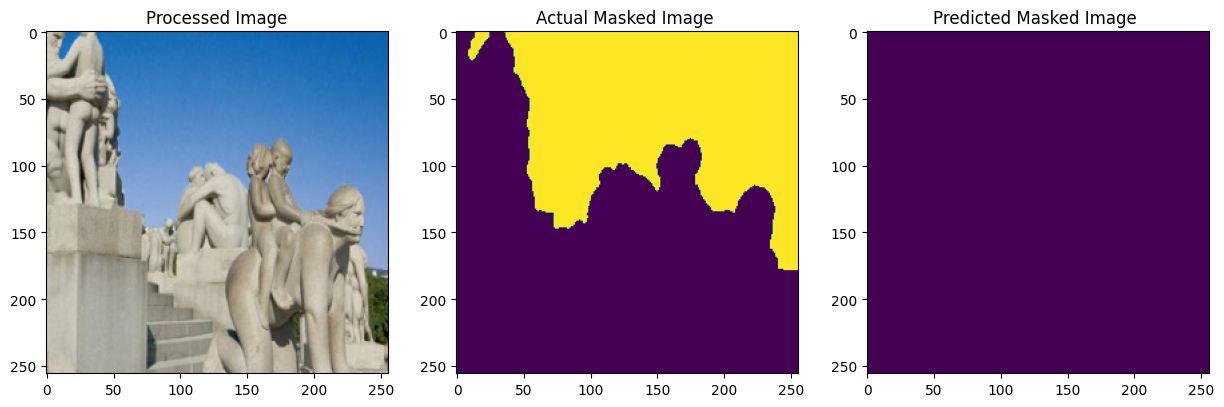

In [ ]:
index = 178
VisualizeResults(index)

In [ ]:
# img = X_valid[19]
# img = img[np.newaxis, ...]
# pred_y = model.predict(img)
# k = pred_y[0]
# print(k)

1/1 [==============================] - 0s 34ms/step


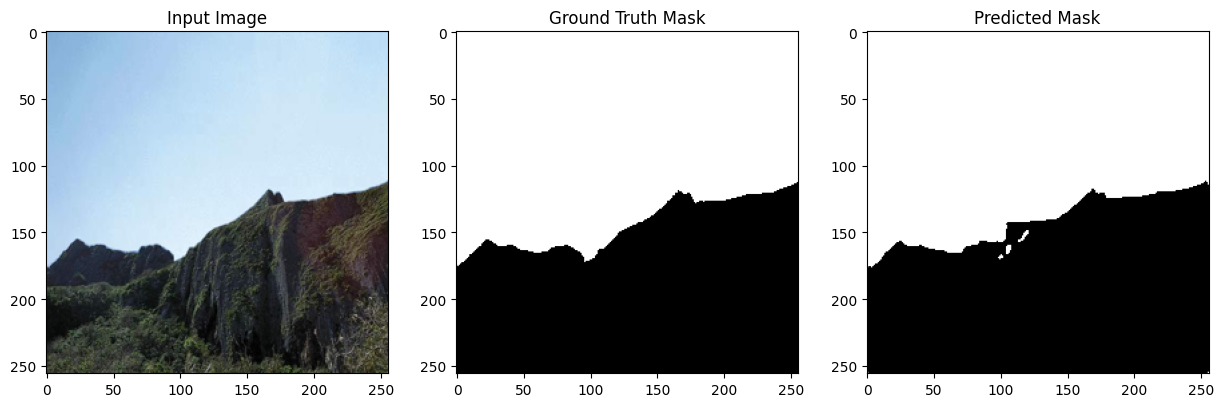

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def VisualizeResults1(index):
    """
    Visualizes the processed image, ground truth mask, and predicted mask for a given index in the validation set.

    Args:
        index: Index of the image to visualize in the validation set.

    Returns:
        None
    """
    img = X_valid[index]
    img = img[np.newaxis, ...]  # Add extra dimension if needed

    # Predict mask
    pred_y = model.predict(img)

    # Process predicted mask
    pred_mask = (pred_y[0, :, :, 0] > 0.15).astype(np.uint8)  # Assuming binary segmentation

    # Extract ground truth mask
    true_mask = y_valid[index, :, :, 0]

    # Plot the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(img[0])

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(true_mask, cmap='gray')
S
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')

    plt.show()

# Example usage
VisualizeResults1(40)


In [ ]:
model.save('/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
